# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  

    - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    - Контролировать добросовестность кассиров при продаже алкоголя.
    
**Задача исследования:**
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.  

**Условия обучения модели:** метрика MAE <= 8.

**Источник данных:** данные с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/).


**Инструкция по выполнению проекта:**
1. Проведите исследовательский анализ набора фотографий.
2. Подготовьте данные к обучению.
3. Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

Импортируем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

In [2]:
SEED = 42

csv_path = '/datasets/faces/labels.csv'
img_path = '/datasets/faces/final_files/'

In [3]:
# Открываем и сохраняем файл labels.csv в датафрейм из директории или по ссылке:
try:
    df = pd.read_csv(csv_path)
except:
    print('Something is wrong')

In [4]:
# Посмотрим полную информацию датафрейма: 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# Смотрим десять случайных строк:
df.sample(10)

,file_name,real_age
4494,004494.jpg,30
535,000535.jpg,22
6169,006172.jpg,25
3681,003681.jpg,23
5890,005891.jpg,33
4120,004120.jpg,1
1131,001131.jpg,7
5090,005090.jpg,59
5192,005192.jpg,26
5297,005297.jpg,1


In [6]:
# Проверим датасет на пропуски
print('Ко-во пропусков:\n', df.isna().sum())

Ко-во пропусков:
 file_name    0
real_age     0
dtype: int64


In [7]:
# Проверим датасет на дубликаты
print('Кол-во дубликатов:', df.duplicated().sum())

Кол-во дубликатов: 0


- В датасете 2 столбца и 7591 записей (фото). Типы данных: object и int64. Выборку можно увеличить с помощью аугментаций для получения лучшего результата.
- Согласно документации к данным, cтолбец `file_name` имя файла изображения, а `real_age` — кол-во лет.
- Датасет не содержит пропусков и дубликатов.
- Выборку можно увеличить с помощью аугментаций для получения лучшего результата.

In [8]:
# Посмотрим на распределение данных:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


- Все фотографии имеют присвоенный возраст. Он находится в диапазоне от 1 до 100 лет.
- Средний возраст 31.2 года, медианный 29, что говорит о смещении распределения.

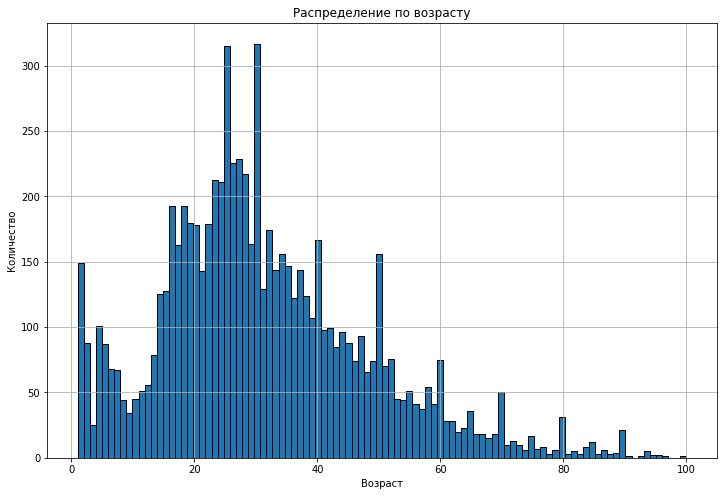

In [9]:
# Построим график распределения фотографий по возрасту:
plt.figure(figsize=(12,8))
plt.hist(df['real_age'], bins=100, edgecolor='black')
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True);

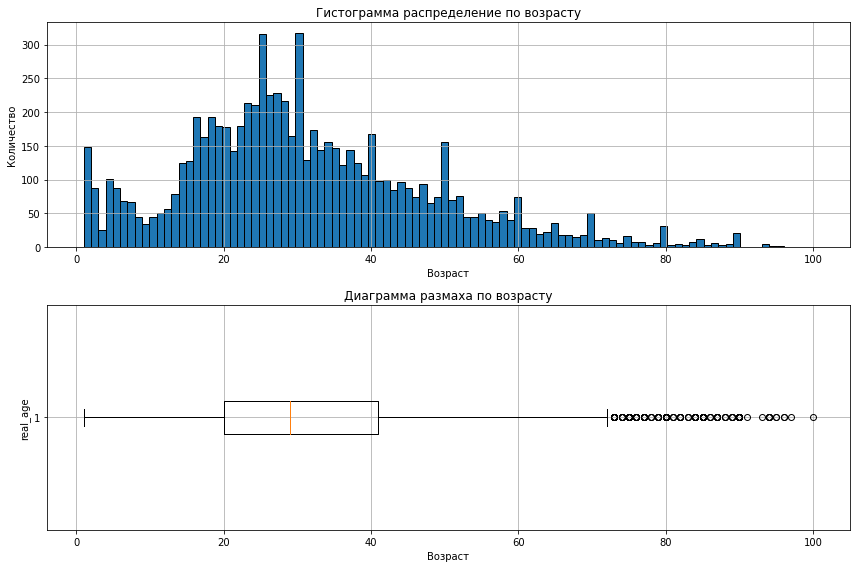

In [10]:
plt.subplots(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.hist(df['real_age'], bins=100, edgecolor='black')
plt.title('Гистограмма распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.boxplot(df['real_age'], vert=False)
plt.title('Диаграмма размаха по возрасту')
plt.xlabel('Возраст')
plt.ylabel('real_age')
plt.grid(True)
 
plt.tight_layout()
plt.show()

- Возраст людей на фото составляет от года до 100 лет, наибольшее число с возрастом от 18 до 40 лет. Также можно увидеть пики на значениях, кратных 1,30, 40 , 50 и тд., можно предположить, что на таких фото возраст определялся примерно и округлялся.

In [11]:
# Инициализируем загрузчик:
datagen = ImageDataGenerator(rescale=1./255)

# Загрузим фотографии:
gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory= img_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=SEED)

Found 7591 validated image filenames.


In [12]:
# Проверим результат загрузки
features, target = next(gen_flow)

features.shape

(32, 224, 224, 3)

Признаки — четырёхмерный тензор, в котором батч из 32 изображений размером 224x224 с тремя цветовыми каналами.

In [13]:
target.shape

(32,)

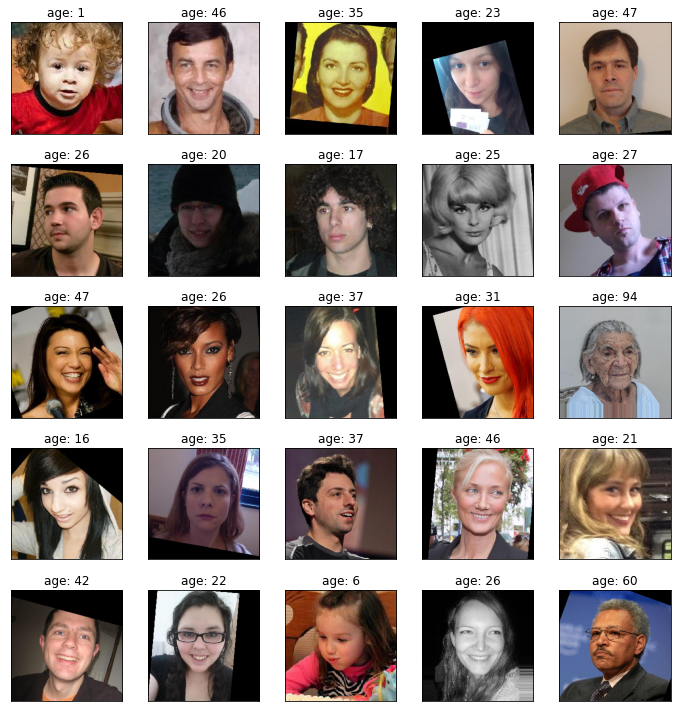

In [14]:
# Посмотрим фотографии:
fig = plt.figure(figsize=(10,10))
for i in range(25):
    fig.add_subplot(5,5, i+1)
    plt.imshow(features[i])
    plt.title(f'age: {target[i]}')    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

- В наборе данных содержатся фото как цветные так и ч/б. Фотографии выглядят хорошо, без явных искажений в области лица. 
- На фотографиях присутствуют объекты, которые закрывают лицо: рука, очки, головной убор и т.д.
- К изображениям применены ~~аугментации~~ алгоритмы компьютерного зрения - определенены лица и вырезаны из фото, фото повернуты так, чтобы лицо располагалось вертикально.
- Из аугментаций к датасету можно применить также `horizontal_flip` - это позволит увеличить выборку.

***Выводы:***
- В датасете 2 столбца и 7591 записей (фото). Типы данных: object и int64. Выборку можно увеличить с помощью аугментаций для получения лучшего результата.
- Согласно документации к данным, cтолбец `file_name` имя файла изображения, а `real_age` — кол-во лет.
- Датасет не содержит пропусков и дубликатов.
- Все фотографии имеют присвоенный возраст. Он находится в диапазоне от 1 до 100 лет.
- Средний возраст 31.2 года, медианный 29, что говорит о смещении распределения.
- Возраст людей на фото составляет от года до 100 лет, наибольшее число с возрастом от 18 до 40 лет. Также можно увидеть пики на значениях, кратных 1,30, 40 , 50 и тд., можно предположить, что на таких фото возраст определялся примерно и округлялся.
- В наборе данных содержатся фото как цветные так и ч/б. Фотографии выглядят хорошо, без явных искажений в области лица. 
- На фотографиях присутствуют объекты, которые закрывают лицо: рука, очки, головной убор и т.д.
- К изображениям уже применены аугментации - определенены лица и вырезаны из фото, фото повернуты так, чтобы лицо располагалось вертикально.
- Из аугментаций к датасету можно применить также `horizontal_flip` - это позволит увеличить выборку.

## Обучение модели

Разбор поставленной перед исследованием задачи:

Параметр | Значение
--- | --- |
Тип решаемой задачи | Задача регрессии
Количество выходных нейронов | 1
Функция активации для нейрона | ReLU
Функция потерь | MSE
Метрики | MAE
Порог для функции потерь | $ <= 8 $
Подход к решению задачи | Нейронные сети
Нейронная сеть | ResNet50
Предобученная | Да
Веса нейронной сети | `weights='imagenet'`
Заморозка сети | Не требуется
Ограничение по времени работы | $ - $
Произведение вычислений | GPU Yandex Compute Cloud
Аугментации данных | `horizontal_flip`

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >

import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


# функция загрузки тренировочных данных
def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    # создание загрузчика данных
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       validation_split=0.20, 
                                       horizontal_flip=True)
    
    # загрузка данных (по частям/батчам)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe = labels, 
                                                           directory = (path + 'final_files/'), 
                                                           x_col='file_name',
                                                           y_col='real_age',     
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           shuffle=True,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=42)
    return train_datagen_flow

# функция загрузки тестовых (валидационных) данных
def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe = labels, 
                                                         directory = (path + 'final_files/'),
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         shuffle=False,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=42)

    return test_datagen_flow


# функция создания нейронной сети
def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


# функция обучения нейронной сети
def train_model(model, train_data, test_data, batch_size=None,
                epochs=15, steps_per_epoch=None, validation_steps=None):


    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)


    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)



```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Train for 190 steps, validate for 48 steps
Epoch 1/15
2024-07-15 08:49:01.296035: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-15 08:49:01.645707: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 60s - loss: 212.8381 - mae: 10.5370 - val_loss: 719.7542 - val_mae: 21.7273
Epoch 2/15
190/190 - 50s - loss: 74.4498 - mae: 6.5607 - val_loss: 681.1691 - val_mae: 20.9720
Epoch 3/15
190/190 - 49s - loss: 46.4694 - mae: 5.2298 - val_loss: 489.4780 - val_mae: 17.3231
Epoch 4/15
190/190 - 49s - loss: 34.8305 - mae: 4.5139 - val_loss: 106.2349 - val_mae: 7.8593
Epoch 5/15
190/190 - 49s - loss: 27.6365 - mae: 4.0133 - val_loss: 72.2280 - val_mae: 6.2908
Epoch 6/15
190/190 - 49s - loss: 20.0565 - mae: 3.4514 - val_loss: 64.5987 - val_mae: 5.9775
Epoch 7/15
190/190 - 49s - loss: 16.7072 - mae: 3.1376 - val_loss: 61.2949 - val_mae: 5.8180
Epoch 8/15
190/190 - 50s - loss: 13.3226 - mae: 2.7650 - val_loss: 66.2088 - val_mae: 5.9212
Epoch 9/15
190/190 - 49s - loss: 11.2959 - mae: 2.5536 - val_loss: 64.4190 - val_mae: 5.8742
Epoch 10/15
190/190 - 50s - loss: 9.6860 - mae: 2.3312 - val_loss: 65.1167 - val_mae: 5.7974
Epoch 11/15
190/190 - 50s - loss: 8.4690 - mae: 2.2107 - val_loss: 65.4018 - val_mae: 6.0862
Epoch 12/15
190/190 - 49s - loss: 7.8557 - mae: 2.1148 - val_loss: 59.7930 - val_mae: 5.7053
Epoch 13/15
190/190 - 49s - loss: 7.2672 - mae: 2.0434 - val_loss: 60.4275 - val_mae: 5.6216
Epoch 14/15
190/190 - 49s - loss: 6.6782 - mae: 1.9442 - val_loss: 62.5256 - val_mae: 5.8113
Epoch 15/15
190/190 - 48s - loss: 6.7932 - mae: 1.9767 - val_loss: 58.7579 - val_mae: 5.5720
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 10s - loss: 58.7579 - mae: 5.5720
Test MAE: 5.5720
```

## Анализ обученной модели

С помощью сети ResNet50, предобученной на датасете ImageNet, было получено значение МАЕ = 5.57, что полностью удовлетворяет условию обучения модели метрика MAE <= 8, то есть при определении возраста модель ошибается в среднем на 5.57 лет.

Это делает модель непригодной для анализа возраста при продаже алкоголя. Для этой задачи можно реализовать отдельную модель классифицирующую людей на две категории. Однако модель может быть полезной для того, чтобы предлагать товары, которые могут заинтересовать покупателей определенной возрастной группы - здесь такая погрешность допустима.

Основное обучение проходит в течение первых 4 эпох. Последующие эпохи (5-15) позволяют улучшить результат предсказаний, но с каждой итерацией прирост качества становиться менее значительным.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы